In [1]:
print('What\'s up?')

What's up?


## Notebook Imports

In [155]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split


%matplotlib inline

## Constants


In [203]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

# print(type('message'))
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

# Adds line into lines list if it is in the body of the email
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n': # looks for empty lines
        is_body  = True

stream.close()

email_body = '\n'.join(lines) # concatenate lines at \n
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2 # Outputs an object

In [8]:
for i in generate_squares(5):
    print(i, end='->')

0->1->4->9->16->

## Email body extraction

In [9]:
def email_bdy_generator(path):

    for root, dirnames, filenames in walk(path):
    # walk, an OS function, generates the file names in a directory by
    # walking the tree from top to bottom. 
    # yields a tuple
        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            # Adds line into lines list if it is in the body of the email
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n': # looks for empty lines
                    is_body  = True

            stream.close()

            email_body = '\n'.join(lines) # concatenate lines at \n
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []

    for file_name, email_body in email_bdy_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)

    return pd.DataFrame(rows, index=row_names)

In [11]:
# spam_emails_1 = df_from_directory(SPAM_1_PATH, 1)
# spam_emails_2 = df_from_directory(SPAM_2_PATH,1)
# spam_emails = pd.concat([spam_emails_1,spam_emails_2])

# Simplified above
spam_emails = pd.concat([df_from_directory(SPAM_1_PATH, 1),df_from_directory(SPAM_2_PATH,1)])
spam_emails.head()

MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   

                                        CATEGORY  
00001.7848dde101aa985090474a91ec93fcf0         1  
00002.d94f1b97e48ed3b553b3508d116e6a09         1  
00003.2ee33bc6eacdb11f38d052c44819ba6c         1  
00004.eac8de8d759b7e74154f142194282724         1  
00005.57696a39d7d84318ce497886896bf90d         1

In [12]:
spam_emails.shape

(1898, 2)

In [13]:
# Challenge: Create a dataframe containing the non-spam emails. 
# PrinT out the shape of this dataframe. 

ham_emails = pd.concat([df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT),df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)])
ham_emails.head()
ham_emails.shape

(3901, 2)

In [14]:
# Combines both spam and ham dataframes into one
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)


Shape of entire dataframe is  (5799, 2)


## Data Cleaning: Checking for Missing Values

In [15]:
# Check if any message bodies are null
# Chained methods and attributes
data.MESSAGE.isnull().values.any()

False

In [16]:
# What would be considered a missing value? 
my_var = None
type(my_var)

NoneType

In [17]:
# Check if there are any empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()


True

In [18]:
# There are empty email but we dont know how many
(data.MESSAGE.str.len() == 0).any().sum()

1

In [19]:
# Challenge: how would you check the number of entries with null/None values? 
data.MESSAGE.isnull().sum()

0

## Locate empty emails

In [20]:
# Find row names of empty emails
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [21]:
data[data.MESSAGE.str.len() == 0].index
#cmds is a system file not an email

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [22]:
# data.index.get_loc('.DS_store')
# data[4608:4611]

## Remove System File Entries from Dataframe

In [23]:
# shape before rows are dropped
data.shape

(5799, 2)

In [24]:
# data = data.drop(['cmds'], inplace=True)

# Does the same as code above
data.drop(['cmds'], inplace=True)

# shape after unwanted rows are dropped
data.shape

(5796, 2)

## Add Document IDs to Track Emails in Dataset

In [25]:
# Note: Row indeces are not numbers, they are file names
document_ids = range(0, len(data.index))
# adds a new column with document ids
data['DOC_ID'] = document_ids


In [26]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [27]:
# Puts file names from index to a new column
data['FILE_NAME'] = data.index

# Changes indeces into the data_ids
data.set_index('DOC_ID', inplace=True)
data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [28]:
data.tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

# Save to File using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualized (Pie Charts)

In [30]:
# Breakdown of the values in a column of the dataframe
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

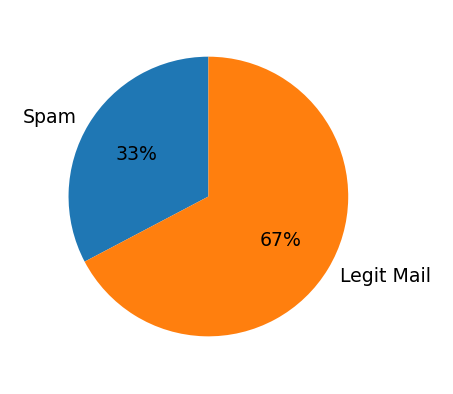

In [32]:
category_names =['Spam', 'Legit Mail']
sizes  = [amount_of_spam, amount_of_ham]


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90,
        autopct='%1.0f%%')
plt.show()

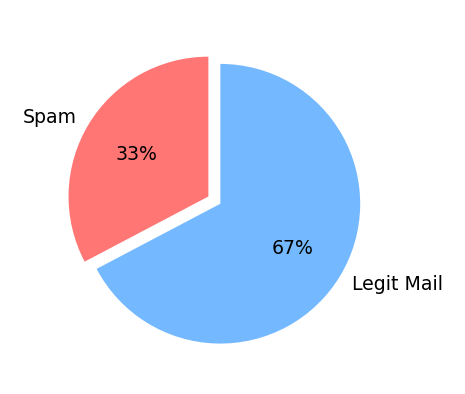

In [33]:
category_names =['Spam', 'Legit Mail']
sizes  = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, explode=[0,0.1])
plt.show()

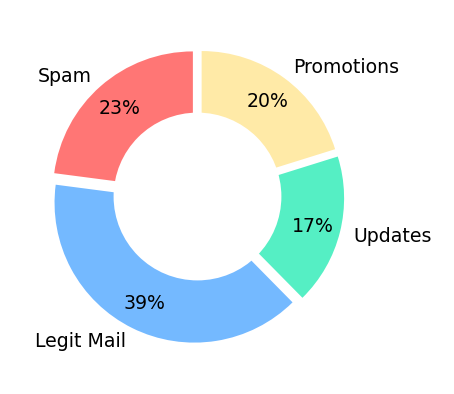

In [34]:
category_names =['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes  = [25, 43,19,22]
custom_colors = ['#ff7675','#74b9ff','#55efc4', '#ffeaa7']
offset = [0.05,0.05,0.05,0.05]


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle 
center_circle = plt.Circle((0,0), radius= 0.6, fc='white')
plt.gca().add_artist(center_circle) # gca is get curret axis 
plt.show()

## Natural Language Processing
### Text Pre-Processing

In [35]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

In [36]:
# imoprt nltk
# from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# Tokenizing

### Download the NLTK Resources (Tokenizer & Stopwords)


In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
# Split sentence into a list of words all in lower case
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stop Words

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
stop_words = set(stopwords.words('english'))

In [41]:
if 'hello' in stop_words: print('Found it')

In [42]:
# Challenge: print out "Nope. Not in here." if the workd "hello" is not contined in stop words. 
if 'hello' not in stop_words: print('Nope. Not in here.')

Nope. Not in here.


In [43]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words: 
    if word not in stop_words:
        filtered_words.append(word)
    # Code below is not necessary
    # else:
    #     continue
print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [44]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()

# from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') 

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words: 
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
    
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuations

In [45]:
# Checks if it is a punctuation. 
'p'.isalpha()

True

In [46]:
'?'.isalpha()

False

In [47]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english') 
filtered_words = []

for word in words: 
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
    
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [48]:
# from bs4 import BeautifulSoup
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [49]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [50]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())

    filtered_words = []

    for word in words:
        # Removes the stop words and punctutation
        if word not in stop_words and word.isalpha():
           filtered_words.append(stemmer.stem(word))

    return filtered_words

In [51]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [85]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 

def clean_msg_no_html(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()

    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())

    filtered_words = []

    for word in words:
        # Removes the stop words and punctutation
        if word not in stop_words and word.isalpha():
           filtered_words.append(stemmer.stem(word))
        #    filtered_words.append(word) # Shows full words for word cloud

    return filtered_words

In [53]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guaranteed',
 'lose',
 'lbs',
 'days',
 'http',
 'get',
 'child',
 'support',
 'deserve',
 'free',
 'legal',
 'advice',
 'http',
 'join',
 'web',
 'fastest',
 'growing',
 'singles',
 'community',
 'http',
 'start',
 'private',
 'photo',
 'album',
 'online',
 'http',
 'wonderful',
 'day',
 'offer',
 'manager',
 'prizemama',
 'wish',
 'leave',
 'list',
 'please',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenization to all messages

### Slicing Dataframes and Series & Creating Subsets

In [54]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [55]:
data.iloc[5:11]

MESSAGE  CATEGORY  \
DOC_ID                                                                
5       A POWERHOUSE GIFTING PROGRAM You Don't Want To...         1   
6       Help wanted.  We are a 14 year old fortune 500...         1   
7       <html>\n\n<head>\n\n<title>ReliaQuote - Save U...         1   
8       TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...         1   
9       Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...         1   
10      Cellular Phone Accessories All At Below Wholes...         1   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [56]:
first_emails = data.MESSAGE.iloc[0:3]
## applies a function - pandas
nested_list = first_emails.apply(clean_message)

In [57]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)


# List comprehension
flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

321

In [58]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [59]:
# use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\tanic\AppData\Local\Temp\ipykernel_31400\2730721891.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\tanic\AppData\Local\Temp\ipykernel_31400\2730721891.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [60]:
nested_list.head()

DOC_ID
0    [save, life, insurance, spend, life, quote, sa...
1    [fight, risk, cancer, http, slim, guaranteed, ...
2    [fight, risk, cancer, http, slim, guaranteed, ...
3    [adult, club, offers, free, membership, instan...
4    [thought, might, like, slim, guaranteed, lose,...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [61]:
data[data.CATEGORY == 1].shape
# data[data['CATEGORY'] == 1].shape

(1896, 3)

In [62]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively.

doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [63]:
doc_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [64]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [65]:
type(nested_list)

pandas.core.series.Series

In [66]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [67]:
nested_list_ham.shape

(3900,)

In [68]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [69]:
nested_list_spam.shape

(1896,)

In [70]:
# Challenge : use python list comprehension and find the total number
# of wordsin our cleaned dataset of spam email bodies. Also find the total
# number of words in normal emails in the dataset. 
# Then find the 10 most common words used in spam. 
# Also find the 10 most common words used in non-spam messages. 

flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

30098

In [71]:
normal_words[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
Name: count, dtype: int64

In [72]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

18022

In [73]:
spammy_words[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
Name: count, dtype: int64

## Creating a Wordcloud

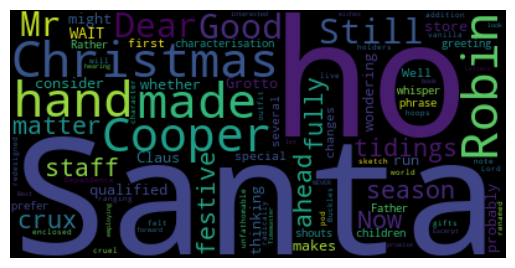

In [74]:
# from wordcloud import WordCloud
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
# Downloads novel wordlists
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\tanic\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\tanic\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [76]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [77]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [78]:
# token to list to one string
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

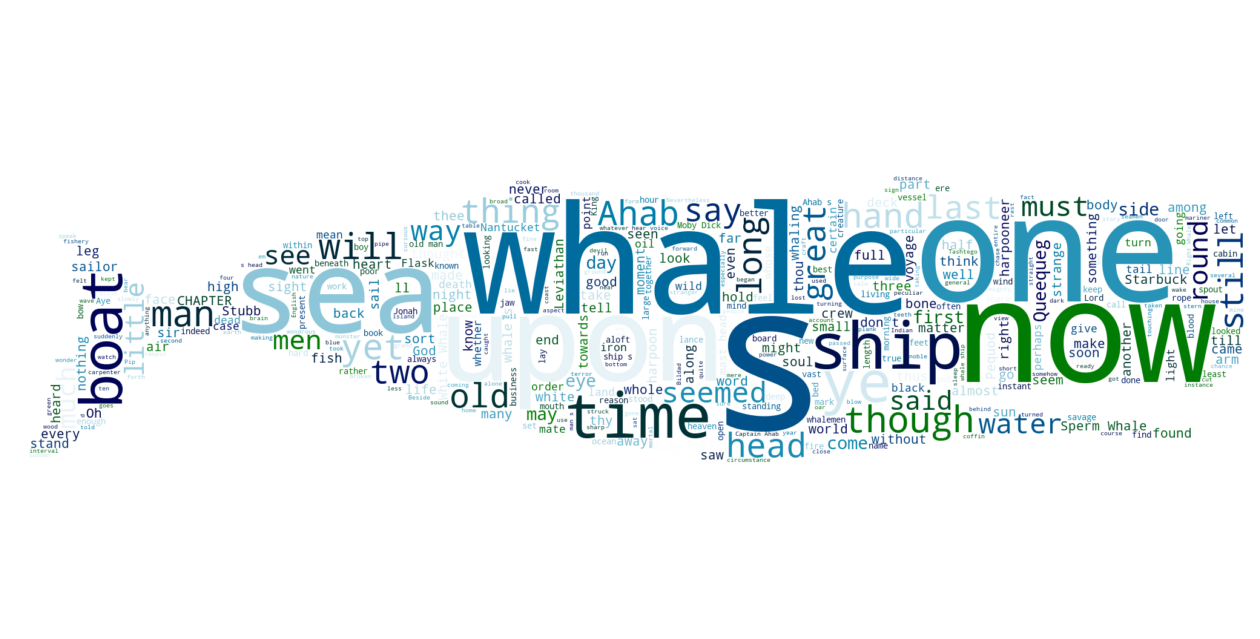

In [79]:
# from wordcloud import WordCloud
# from PIL import Image

# mask preparation
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object to an array


word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,18])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

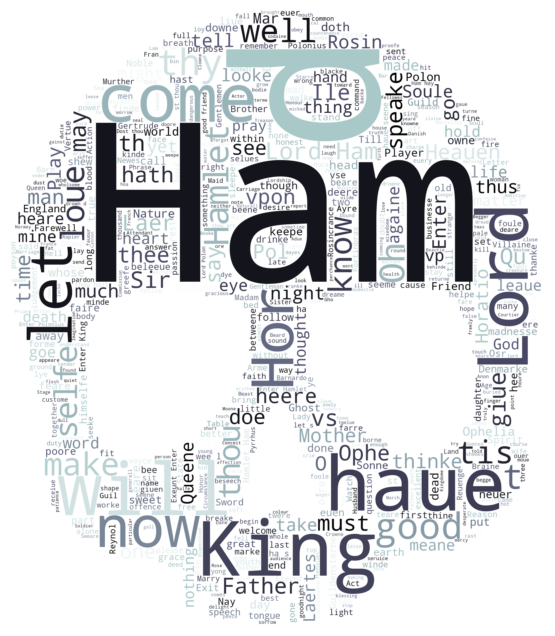

In [80]:
# Challenge : use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255,255,255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask) # converts the image object to an array


word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=600, colormap='bone')
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Word Cloud of Ham and Spam Messages

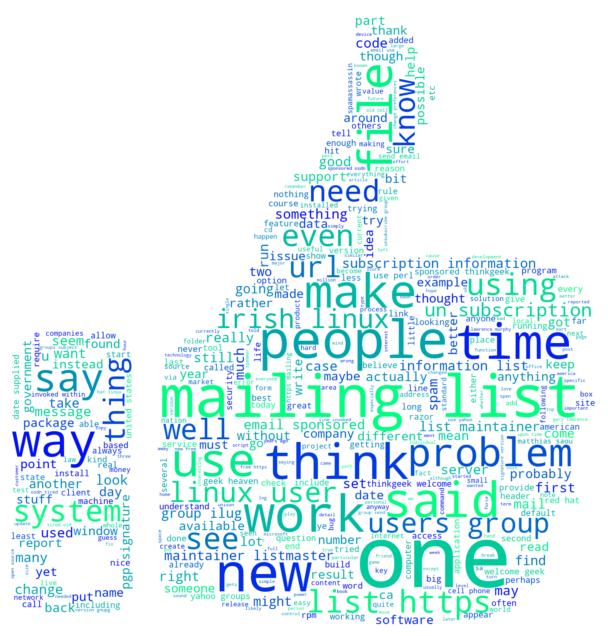

In [81]:
# from wordcloud import WordCloud
# from PIL import Image

# mask preparation
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
# Challenge: look at the word cloud documentation. Use the custom font
# included in the lesson resources instead of the default font and create a word cloud of the spammy words


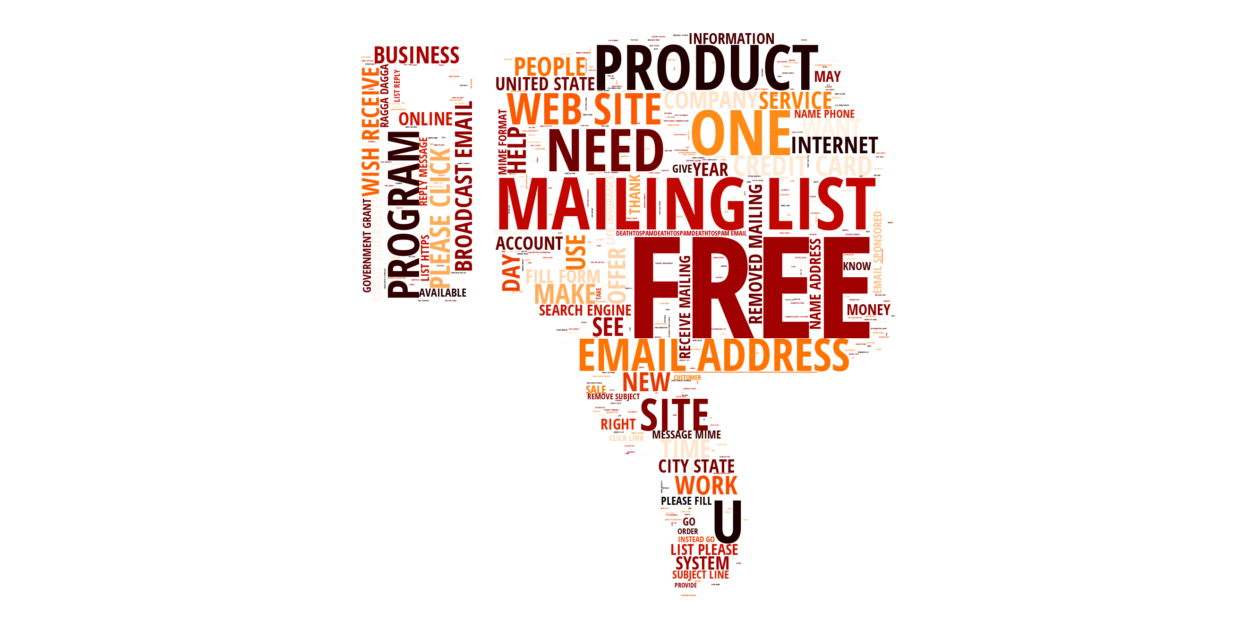

In [83]:
# from wordcloud import WordCloud
# from PIL import Image
# CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
# mask preparation
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='gist_heat', font_path=CUSTOM_FONT_FILE,
                       max_font_size=300)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [84]:
print(flat_list_spam)

['save', 'life', 'insurance', 'spend', 'life', 'quote', 'savings', 'g', 'family', 'financial', 'security', 'important', 'life', 'quote', 'savings', 'kes', 'buying', 'life', 'insurance', 'simple', 'affordable', 'provide', 'free', 'access', 'best', 'companies', 'lowest', 'rates', 'life', 'quote', 'savings', 'fast', 'saves', 'money', 'let', 'us', 'help', 'get', 'started', 'best', 'ues', 'country', 'new', 'coverage', 'save', 'hundreds', 'even', 'usands', 'dollars', 'requesting', 'free', 'quote', 'lifequote', 'savings', 'service', 'take', 'less', 'minutes', 'complete', 'shop', 'compare', 'save', 'types', 'life', 'insurance', 'click', 'free', 'quote', 'protecting', 'family', 'best', 'investment', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'removed', 'list', 'please', 'click', 'type', 'remove', 'reside', 'state', 'prohibits', 'solicitations', 'ce', 'please', 'disregard', 'email', 'fight', 'risk', 'cancer', 'http', 'slim', 'guaranteed', 'lose', 'lbs', 'days', 'http', 'get', 'child', 'su

## Generate Vocabulary and Dictionary

In [86]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\tanic\AppData\Local\Temp\ipykernel_31400\2484622151.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\tanic\AppData\Local\Temp\ipykernel_31400\2484622151.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [87]:
# Vocabulary
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [94]:
# Challenge: Crete subset of the series called 'frequent_words' that
# only contains the most common 2,500 words out of the total. 
# Print out the top 10 words. 


frequent_words = unique_words[0:VOCAB_SIZE]
# frequent_words.head(10)

# Solution from lesson: 
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


## Create Vocabulary DataFrame with a WORD_ID


In [99]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

## Save the Vocabulary as a CSV File

In [102]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Exercise: Checking if a Word is Part of the Vocabulary 

In [ ]:
# Challenge: Write a line of code that checks if a particular word 
# is part of the vocabulary. Your code should return True if the word is 
# among the 2,500 words that comprise the vocabulary, and False otherwise. 
# Check these words:
# machine
# learning
# fun
# learn 
# data
# science
# app
# brewery

In [125]:
# My solution, inefficient
# vocab.isin(['machine']).value_counts()

# Lesson solution
# any(vocab.VOCAB_WORD == 'machine') # inefficient
'machine' in set(vocab.VOCAB_WORD) # better way

False

## Exercise: Find the Email with the Most Number of Words

In [146]:
# Challenge: Print out the number of words in the longest email
# (after cleaning & stemming)
# Note the longest email's position in the list of cleaned emails. 
# Print out the stemmed list of words in the longest email. 
# Print out the longest email from the dataframe. 

# My solution
email_length = int()
index = int()
for i in range(len(stemmed_nested_list)):
    length = len(stemmed_nested_list[i])
    if length > email_length:
        email_length = length
        index = i

print(f'The list of words are ({email_length} words):', stemmed_nested_list[index])
print(f'The longest email is in index {index}:', data.MESSAGE[index])


## Lesson solution
# clean_email_lengths = []
# for sublist in stemmed_nested_list:
#     clean_email_lengths.append(len(sublist))
# print(clean_email_lengths)

## List comprehension
# clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
# print('Nr words in the longes email:', max(clean_email_lengths))
# print('Email position in the list (and the dataframe)', np.argmax(clean_email_lengths))

The list of words are (7671 words): ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', 'filenam', 'consid', 'f

In [147]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [148]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features and a Sparse Matrix
### Creating a DataFrame with one Word per Column

In [150]:
type(stemmed_nested_list)
# is a series that is composed of lists. 


pandas.core.series.Series

In [152]:
# Convert series of lists to list of lists
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()


0      1       2      3           4         5       6     7       8     \
0     save   life   insur  spend        life      quot    save     g  famili   
1    fight   risk  cancer   http        slim  guarante    lose    lb     day   
2    fight   risk  cancer   http        slim  guarante    lose    lb     day   
3    adult   club   offer   free  membership   instant  access  site    user   
4  thought  might    like   slim    guarante      lose      lb   day    http   

      9     ...  7661  7662  7663  7664  7665  7666  7667  7668  7669  7670  
0  financi  ...  None  None  None  None  None  None  None  None  None  None  
1     http  ...  None  None  None  None  None  None  None  None  None  None  
2     http  ...  None  None  None  None  None  None  None  None  None  None  
3     name  ...  None  None  None  None  None  None  None  None  None  None  
4    fight  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 7671 columns]

In [153]:
word_columns_df.shape
# 5796 total emails
# 7671 number of stemmed words in longest email

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [158]:
# Challenge: Split the data into a training and testing set? 
# Set the test size at 30%. 
# The training data should inclued 4057 emails. Use a seed value of 42 to shuffle. 
# What are the target values? 


# from sklearn.model_selection import train_test_split
# Target values are the CATEGORIES
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, 
                                                    test_size = 0.3, random_state=42)


0.6999654934437544

In [164]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set,' , X_train.shape[0]/word_columns_df.shape[0])
X_train.index.name = X_test.index.name = 'DOC_ID' # changes index name in both X test and X train
X_train.head()

Nr of training samples 4057
Fraction of training set, 0.6999654934437544


0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [165]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the Training Data
### Using the following:

X_ traing dataframe 

y_train pandas series 

vocabulary words 


In [168]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [169]:
word_index.get_loc('thu')

393

In [170]:
# not in the vocabulary so it will not be added in the sparse matrix
# word_index.get_loc('rodent')

KeyError: 'rodent'

In [181]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe. 

    df: A dataframe with words in the columns with a document id as an index (X_ train or X_ test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id,
                        'OCCURENCE': 1, 'WORD_ID': word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)




In [182]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [183]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1      265
1      0    4844          1     1243
2      0    4844          1      502
3      0    4844          1      308
4      0    4844          1      254

In [184]:
sparse_train_df.shape

(429241, 4)

In [187]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURENCE  WORD_ID
429236      1     860          1       47
429237      1     860          1     1431
429238      1     860          1       26
429239      1     860          1       21
429240      1     860          1      126

### Combine Occurences with the Pandas groupby() Method
### Similar to excel pivot tables

In [188]:
# Combines occurences/ duplicates?
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

## Shows how many times a word shows up

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [191]:
vocab.at[0,'VOCAB_WORD']

'email'

In [192]:
data.MESSAGE[0]

"##################################################\n\n#                                                #\n\n#                 Adult Club                     #\n\n#           Offers FREE Membership               #\n\n#                                                #\n\n##################################################\n\n\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n\n>>>>>  Your User Name And Password is.\n\n>>>>>  User Name: zzzz@spamassassin.taint.org\n\n>>>>>  Password: 760382\n\n\n\n5 of the Best Adult Sites on the Internet for FREE!\n\n---------------------------------------\n\nNEWS 08/18/02\n\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n\nMembers. Are you one of them yet???\n\n---------------------------------------\n\nOur Membership FAQ\n\n\n\nQ. Why are you offering free access to 5 adult membership sites for free?\n\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\n\n\nQ. Is it true m

In [193]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      1          1
1       0        3      1          2
2       0        4      1          1
3       0        7      1          3
4       0       11      1          1

The line of code train_grouped = train_grouped.reset_index() performs the following operations:

Resets the Index: The reset_index() method is called on the train_grouped DataFrame. This method resets the index of the DataFrame to the default integer index and converts the current index into a column.

Return a New DataFrame: The result of reset_index() is a new DataFrame where the original index is now a column in the DataFrame, and the DataFrame has a default integer index (0, 1, 2, ...).

Assign Back to Original Variable: The new DataFrame with the reset index is then assigned back to the train_grouped variable, effectively updating the variable with the new DataFrame.

In [194]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
258355    5795     2035      0          2
258356    5795     2040      0          1
258357    5795     2272      0          1
258358    5795     2342      0          1
258359    5795     2370      0          1

In [197]:
vocab.at[2035,'VOCAB_WORD'] # occurs 2 times as shown at the tail

'swap'

In [198]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [199]:
# dataframe reduction
train_grouped.shape

(258360, 4)

### Save Training Data as .txt File


In [201]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [202]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [204]:
# Challenge: 
# Create a sparse matrix for the test data. Group the occurrences of the
# same word in the same email. Then save the data as a .txt file. 

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)


In [205]:
sparse_test_df.shape

(203366, 4)

In [206]:

test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        2      1          1
1       8        3      1          4
2       8        4      1          2
3       8        5      1          1
4       8        6      1          2

In [207]:
test_grouped.shape

(117776, 4)

In [208]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt files? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out. 

In [209]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [210]:
len(train_doc_ids) # number of individual emails in the training set
len(test_doc_ids) # number of individual emails in the testing set

4013

In [211]:
len(X_test)

1739

In [213]:
# Which ones were included and which one were not? 
# Use sets to check for membership
set(X_test.index) - test_doc_ids
# Outputs the emails that did not make it to the test set

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [223]:
# Maybe the issue was due to encoding used? 
data.MESSAGE[179]

'------=_NextPart_000_00A5_78C83A6B.A1543A16\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nMzU0NHRqVFIwLTM5NUZLa20zNjkyYUN6QjUtNDQ5cGVsMzANCjxodG1sPjxi\n\nb2R5IGxpbms9I0ZGRkYwMCB2bGluaz0jRkZGRjAwIGFsaW5rPSNGRkZGMDAg\n\ndGV4dD0jRkZGRjAwIGJnY29sb3I9IzAwMDAwMD4gPHRhYmxlIGJvcmRlckNv\n\nbG9yPSMwMDAwMDAgd2lkdGg9NjAwIGFsaWduPWNlbnRlciBiZ0NvbG9yPSM2\n\nNjk5MzMgYm9yZGVyPTM+PHRyPjx0ZCBhbGlnbj1taWRkbGU+PGZvbnQgZmFj\n\nZT1BcmlhbCxIZWx2ZXRpY2Esc2Fucy1zZXJpZj48YnI+IDxmb250IGNvbG9y\n\nPXdoaXRlIHNpemU9KzM+PGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5l\n\ndC93ZXRiaXRzL2luZGV4Lmh0bT5XZXRiaXRzPC9hPjwvZm9udD48L2ZvbnQ+\n\nPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5ldC93ZXRiaXRzL2luZGV4\n\nLmh0bT4gPC9hPjxwPjxmb250IGZhY2U9QXJpYWwsSGVsdmV0aWNhLHNhbnMt\n\nc2VyaWYgY29sb3I9I2ZmZmYwMCBzaXplPTM+PGI+IEdvbGRlbiBTaG93ZXIg\n\nRXh0cmF2YWdhbnphPC9iPjwvZm9udD48Zm9udCBmYWNlPUFyaWFsLEhlbHZl\n\ndGljYSxzYW5zLXNlcmlmPjxicj4gPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1h\n\ndGNoLm5ldC93ZXRiaXRzL2luZG

In [215]:
data.loc[134]

MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86\n\...
CATEGORY                                                     1
FILE_NAME               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object

In [225]:
clean_msg_no_html(data.at[179, 'MESSAGE'])
# output string not in the vocabulary since its a 'gibberish' string
# another possible issue is that the body of the email is all just html tags


[]